In [1]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd

import catboost
print(catboost.__version__)

1.2.8


In [2]:
# Loading the dataset
df = pd.read_csv('https://gist.githubusercontent.com/meperezcuello/82a9f1c1c473d6585e750ad2e3c05a41/raw/d42d226d0dd64e7f5395a0eec1b9190a10edbc03/Medical_Cost.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Shape
df.shape

(1338, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# Splitting the data
X = df.drop('charges', axis=1)
y = df['charges']
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [6]:
# CatBoost need's to know which features are categorical
cat_features = [1,3,4,5]
print(cat_features)

[1, 3, 4, 5]


In [7]:
# Model Building and Training
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=10)
model.fit(X, y, cat_features=cat_features, verbose=1)
# verbose = n -> The output of training after every n'th iteration will get printed
# learn -> Loss value (RMSE)
# total -> Total time require till current iteration training
# remaining -> Time require to finish the training

Learning rate set to 0.5
0:	learn: 7787.0489866	total: 130ms	remaining: 1.17s
1:	learn: 5757.3748455	total: 162ms	remaining: 646ms
2:	learn: 5045.9462283	total: 195ms	remaining: 455ms
3:	learn: 4760.7663840	total: 249ms	remaining: 374ms
4:	learn: 4599.9243171	total: 284ms	remaining: 284ms
5:	learn: 4560.8501449	total: 290ms	remaining: 194ms
6:	learn: 4476.8535036	total: 326ms	remaining: 140ms
7:	learn: 4425.1178335	total: 359ms	remaining: 89.6ms
8:	learn: 4402.3112053	total: 390ms	remaining: 43.3ms
9:	learn: 4380.1688426	total: 421ms	remaining: 0us


In [8]:
# Model Presiction
model.predict(X)

array([19654.86890676,  4327.79540466,  6394.05757217, ...,
        3133.7350406 ,  2861.55162174, 34285.14154651], shape=(1338,))

---

## `Pool` Data Structure - Efficiently loading the dataset
- There are several ways of passing dataset to training - using X,y (the initial matrix) or using Pool class.
Pool class is the class for storing the dataset. In the next few blocks we'll explore the ways to create a Pool object.

- You can use Pool class if the dataset has more than just X and y (for example, it has sample weights or groups) or if the dataset is large and it takes long time to read it into python.

In [9]:
from sklearn.model_selection import train_test_split
from catboost import Pool

# Train Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Deep Learning approach - Validation at each epoch
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)

validation_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features
)

In [10]:
# Model Training
model = CatBoostRegressor(
    iterations=5,
    learning_rate=0.1,
    loss_function='RMSE'
)
model.fit(train_pool, eval_set=validation_pool, verbose=False)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1, 'loss_function': 'RMSE'}


In [11]:
# Training and Validating parallaly
model = CatBoostRegressor(
    iterations=15,
    verbose=5,
)
model.fit(train_pool, eval_set=validation_pool) 

Learning rate set to 0.5
0:	learn: 7608.2906506	test: 7667.5765651	best: 7667.5765651 (0)	total: 23.3ms	remaining: 327ms
5:	learn: 4604.5635186	test: 4106.7789446	best: 4106.7789446 (5)	total: 176ms	remaining: 264ms
10:	learn: 4429.2010329	test: 4065.7452484	best: 4039.2627286 (8)	total: 326ms	remaining: 118ms
14:	learn: 4259.1387065	test: 4064.9212176	best: 4039.2627286 (8)	total: 433ms	remaining: 0us

bestTest = 4039.262729
bestIteration = 8

Shrink model to first 9 iterations.


In [12]:
# Visualizing the loss trend of model during training and during validation
model = CatBoostRegressor(
    iterations=50,
    learning_rate=0.5,
    loss_function='RMSE'
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True # Parameter helps to enable visualizing the loss
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

---

In [13]:
# Compairing multiple models
model1 = CatBoostRegressor(
    learning_rate=0.7,
    iterations=100,
    train_dir='model_high_lr'
)
model1.fit(train_pool, eval_set=validation_pool, verbose=20)

model2 = CatBoostRegressor(
    learning_rate=0.01,
    iterations=100,
    train_dir='model_low_lr'
)
model2.fit(train_pool, eval_set=validation_pool, verbose=20)

0:	learn: 6225.1861330	test: 6028.1142804	best: 6028.1142804 (0)	total: 19.7ms	remaining: 1.95s
20:	learn: 4064.4776624	test: 4230.9297514	best: 4166.3947766 (10)	total: 846ms	remaining: 3.18s
40:	learn: 3595.5874566	test: 4293.5019510	best: 4166.3947766 (10)	total: 1.83s	remaining: 2.64s
60:	learn: 3118.0919822	test: 4405.3245592	best: 4166.3947766 (10)	total: 2.75s	remaining: 1.76s
80:	learn: 2816.0249682	test: 4386.6941790	best: 4166.3947766 (10)	total: 3.7s	remaining: 869ms
99:	learn: 2551.5441301	test: 4438.5918733	best: 4166.3947766 (10)	total: 4.61s	remaining: 0us

bestTest = 4166.394777
bestIteration = 10

Shrink model to first 11 iterations.
0:	learn: 11879.7932856	test: 12514.7821306	best: 12514.7821306 (0)	total: 24.4ms	remaining: 2.41s
20:	learn: 10298.1582508	test: 10760.1524741	best: 10760.1524741 (20)	total: 866ms	remaining: 3.26s
40:	learn: 9025.1625771	test: 9336.0675800	best: 9336.0675800 (40)	total: 1.63s	remaining: 2.34s
60:	learn: 8017.1219457	test: 8188.6932839	be

In [14]:
# Visualizing multiple models
from catboost import MetricVisualizer
MetricVisualizer(['model_high_lr', 'model_low_lr']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

---

In [ ]:
model = CatBoostRegressor(
    iterations=100,
    use_best_model=True # It will select the best model (model got least loss amoung all models) among all the models that has been trained 
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [16]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 36


---

In [17]:
# Cross Validation
from catboost import cv

params = {
    'loss_function': 'RMSE',
    'iterations': 80,
    # 'custom_loss': 'MAE',
    'learning_rate': 0.5,
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5, # k - fold cross validation
    shuffle=True,
    plot=True,
    stratified=False # no need for regression
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 11020.4170379	test: 10229.5747867	best: 10229.5747867 (0)	total: 21ms	remaining: 1.66s
1:	learn: 7564.1037916	test: 7145.8261298	best: 7145.8261298 (1)	total: 46ms	remaining: 1.79s
2:	learn: 5706.4232752	test: 5673.1239325	best: 5673.1239325 (2)	total: 72.7ms	remaining: 1.87s
3:	learn: 4959.6268650	test: 5203.0959648	best: 5203.0959648 (3)	total: 96.4ms	remaining: 1.83s
4:	learn: 4702.2309638	test: 5082.9447107	best: 5082.9447107 (4)	total: 145ms	remaining: 2.17s
5:	learn: 4593.7638406	test: 5015.0822851	best: 5015.0822851 (5)	total: 189ms	remaining: 2.33s
6:	learn: 4503.3455425	test: 5012.9967244	best: 5012.9967244 (6)	total: 206ms	remaining: 2.15s
7:	learn: 4426.9323711	test: 4996.7833473	best: 4996.7833473 (7)	total: 230ms	remaining: 2.07s
8:	learn: 4273.4163679	test: 5002.4063084	best: 4996.7833473 (7)	total: 255ms	remaining: 2.01s
9:	learn: 4212.7765043	test: 5005.3501485	best: 4996.7833473 (7)	total: 291ms	remaining: 2.04s
10:	learn: 4201.4802978	

In [18]:
# DataFrame of cross validation
cv_data

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,10910.552582,1079.964769,10858.930456,177.928727
1,1,7688.131595,759.830751,7532.286916,103.499961
2,2,5878.931108,475.681733,5702.507158,79.949880
3,3,5197.244618,331.709921,5009.393445,76.115483
4,4,4949.841276,291.660952,4760.460059,72.409281
...,...,...,...,...,...
75,75,5053.360113,403.637921,2913.615877,114.332149
76,76,5053.810285,400.191665,2894.848321,114.439372
77,77,5049.573600,404.112575,2878.155614,108.647442
78,78,5054.757932,409.054392,2864.293536,117.425037


In [19]:
best_value = np.min(cv_data['test-RMSE-mean'])
best_iter = np.argmin(cv_data['test-RMSE-mean'])

print('Best validation RMSE score: {:.4f}±{:.4f} on iteration {}'.format(
    best_value,
    cv_data['test-RMSE-mean'][best_iter],
    best_iter)
)

Best validation RMSE score: 4760.4100±4760.4100 on iteration 16


---

In [20]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    "learning_rate": [0.001, 0.01, 0.5],
}

clf = CatBoostRegressor(
    iterations=20,
    cat_features=cat_features,
    verbose=20
)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3)
results = grid_search.fit(X_train, y_train)
results.best_estimator_.get_params()

0:	learn: 12101.1885964	total: 23.3ms	remaining: 443ms
19:	learn: 11945.5933585	total: 516ms	remaining: 0us
0:	learn: 11968.0006121	total: 27.4ms	remaining: 520ms
19:	learn: 11808.9334478	total: 699ms	remaining: 0us
0:	learn: 11816.0675780	total: 31.9ms	remaining: 606ms
19:	learn: 11653.8141827	total: 680ms	remaining: 0us
0:	learn: 12021.0930219	total: 20.4ms	remaining: 387ms
19:	learn: 10563.0000735	total: 593ms	remaining: 0us
0:	learn: 11893.2730390	total: 26.1ms	remaining: 496ms
19:	learn: 10441.0750438	total: 496ms	remaining: 0us
0:	learn: 11738.7280820	total: 24.9ms	remaining: 473ms
19:	learn: 10253.6015209	total: 548ms	remaining: 0us
0:	learn: 7978.5386760	total: 18.6ms	remaining: 354ms
19:	learn: 4298.3894185	total: 560ms	remaining: 0us
0:	learn: 8058.9321400	total: 23.8ms	remaining: 453ms
19:	learn: 4061.8040490	total: 691ms	remaining: 0us
0:	learn: 7780.7621946	total: 31.8ms	remaining: 605ms
19:	learn: 3880.3716319	total: 684ms	remaining: 0us
0:	learn: 7608.2906506	total: 16.2

{'iterations': 20,
 'loss_function': 'RMSE',
 'verbose': 20,
 'cat_features': [1, 3, 4, 5],
 'learning_rate': 0.5}

---

In [21]:
# Early Stopping
model_with_early_stop = CatBoostRegressor(
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20 # Threshold?
)

model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
print(model_with_early_stop.tree_count_)

19


---

In [ ]:
model_with_early_stop = CatBoostRegressor(
    eval_metric='R2', # it's not tracking the r2 score, just shows the value of r2 score when the training got stopped
    iterations=200,
    learning_rate=0.2,
    early_stopping_rounds=20 # The early stopping is based on loss function only - RMSE
)

model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [24]:
print(model_with_early_stop.tree_count_)

76


---

In [25]:
# Model Predictions Ways
model = CatBoostRegressor(iterations=200, learning_rate=0.03)
model.fit(train_pool, verbose=50)

0:	learn: 11698.0681489	total: 29.5ms	remaining: 5.86s
50:	learn: 5562.4329865	total: 1.4s	remaining: 4.08s
100:	learn: 4610.5616517	total: 3.03s	remaining: 2.97s
150:	learn: 4404.2985249	total: 4.81s	remaining: 1.56s
199:	learn: 4289.2492600	total: 7.11s	remaining: 0us


In [ ]:
# Final Model Prediction
print(model.predict(X_test))

[13010.33565912 10392.71373727 44809.15103974 13783.61839406
 11203.52985749  4841.91062809  3567.67299567 13640.89543817
  8272.20274849  7064.37999133  6564.62595016 12266.91951971
  9273.62415808  4943.04035862 20081.02357121 12271.37863145
 13525.11900548  6165.75793885  7628.97484448 32181.14535273
 24398.94944378 13973.14208301 11997.59862092 25269.25362529
  3600.32254066  7218.75154912  4389.37025771  8444.36936883
  4558.51510575 10231.83507136  8555.26029751 46289.30238111
 13706.8965822  11992.98656571 17723.60094225  4774.02771564
 10078.30252908 38838.58629654 40256.85224088  3593.86536569
  5485.63669194  4087.64952817 22110.94581569 46091.57207277
 36934.22900537  6134.40984172 12282.77077304  7804.06696728
  5646.60122523 12678.07486878  4509.23234554  5642.2015661
 25015.87923275 45124.90141922 12209.24625707  4955.94678159
  3882.54099003 11203.30002088  8629.96132859 15036.48185943
  3129.55269257 43372.95110072 15973.01704087 11950.02588415
 12440.72719785 12923.899

In [29]:
# You can also get the prediction of intermediate trees
predictions = []
for prediction in model.staged_predict(ntree_end=5, data=X_test): # For 1st 5 tree the prediction is 
    predictions.append(prediction)

pd.DataFrame({f"DT - {i} prediction" : predictions[i] for i in range(len(predictions))}).head()

,DT - 0 prediction,DT - 1 prediction,DT - 2 prediction,DT - 3 prediction,DT - 4 prediction
0,13225.530931,13182.974879,13155.039681,13105.459248,13081.756729
1,13147.273847,13104.717795,13071.103307,13021.522875,12997.820355
2,13963.301830,14811.937981,15674.817725,16262.252676,17062.743676
3,13225.530931,13182.974879,13167.930002,13118.349569,13105.596220
4,13201.181641,13151.825111,13124.343065,13074.762632,13077.735830


---

In [30]:
# Model evaluation on testing data
metrics = model.eval_metrics(
    data=validation_pool,
    metrics=['R2'],
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [31]:
print('R2 score:\n{}'.format(np.array(metrics['R2'])))

R2 score:
[0.0476055  0.09419045 0.13704105 0.17107418 0.20627582 0.233224
 0.26805049 0.29887582 0.32762497 0.35691078 0.38184743 0.40846397
 0.42678117 0.45101735 0.470458   0.48810145 0.50700867 0.5247933
 0.54455093 0.56189701 0.57897667 0.59015672 0.60657234 0.62153603
 0.63517158 0.64923001 0.66258151 0.67504709 0.68702123 0.69824218
 0.70507549 0.7139939  0.72414011 0.73264667 0.74030284 0.74863311
 0.75491661 0.76139972 0.76834235 0.77522373 0.78041802 0.78591667
 0.79164642 0.79729469 0.80240781 0.80705852 0.81100184 0.81559341
 0.81963746 0.82371742 0.82593967 0.82927444 0.83291623 0.83641682
 0.83927108 0.84235281 0.84496723 0.84755655 0.85033869 0.8527761
 0.85445654 0.85634335 0.858658   0.86058071 0.86239015 0.86380236
 0.86473702 0.86619038 0.86756072 0.86905834 0.87093029 0.87247498
 0.87353561 0.87497055 0.87617089 0.87741797 0.87866891 0.87984704
 0.88071964 0.88177728 0.88288225 0.88367337 0.88433998 0.88499502
 0.88585792 0.8865104  0.88707518 0.88775974 0.88804194 

---

## Feature importances

### Prediction values change

Default feature importances for binary classification is PredictionValueChange - how much on average does the model change when the feature value changes.
These feature importances are non negative.
They are normalized and sum to 1, so you can look on these values like percentage of importance.

In [32]:
np.array(model.get_feature_importance(prettified=True))

array([['smoker', 76.31805508436925],
       ['bmi', 12.693505668368188],
       ['age', 8.603279276464882],
       ['children', 1.363812132906847],
       ['region', 0.8408094101656046],
       ['sex', 0.1805384277252453]], dtype=object)

<Axes: title={'center': 'Feature Importance'}>

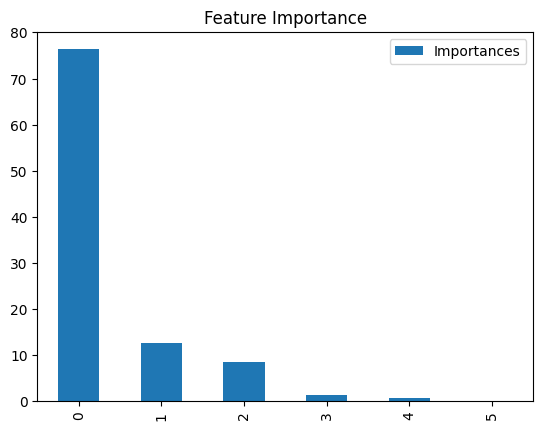

In [33]:
# Plot feature importances
model.get_feature_importance(prettified=True).plot(kind='bar', title='Feature Importance')

### Loss function change

The non default feature importance approximates how much the optimized loss function will change if the value of the feature changes.
This importances might be negative if the feature has bad influence on the loss function.
The importances are not normalized, the absolute value of the importance has the same scale as the optimized loss value.
To calculate this importance value you need to pass train_pool as an argument.

In [34]:
np.array(model.get_feature_importance(
    train_pool,
    type='LossFunctionChange',
    prettified=True
))

array([['smoker', 6262.829741268003],
       ['age', 1292.5628566317873],
       ['bmi', 959.5073119629296],
       ['children', 87.2395469076614],
       ['region', 22.088282256054754],
       ['sex', 5.413669543065225]], dtype=object)

In [35]:
# Compute the interaction strengths
interaction_strengths = model.get_feature_importance(
    train_pool,
    type='Interaction',
)

interaction_strengths

array([[0.        , 3.        , 8.89546955],
       [0.        , 5.        , 8.353932  ],
       [2.        , 5.        , 8.07461239],
       [0.        , 2.        , 7.67368015],
       [2.        , 3.        , 6.82609129],
       [3.        , 5.        , 6.73720189]])

### Shap values

In [36]:
print(model.predict([X.iloc[1,:]]))
print(model.predict([X.iloc[91,:]]))

[4599.29080154]
[12762.9175922]


In [37]:
shap_values = model.get_feature_importance(
    validation_pool,
    'ShapValues'
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(268, 6)


In [38]:
proba = model.predict([X.iloc[1,:]])[0]
raw = model.predict([X.iloc[1,:]], prediction_type='RawFormulaVal')[0]
print('Probabilities', proba)
print('Raw formula value %.4f' % raw)

Probabilities 4599.290801539781
Raw formula value 4599.2908


In [39]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_test.iloc[1,:])

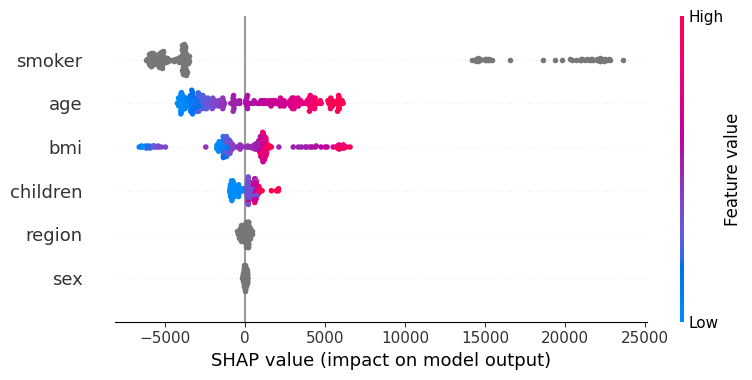

In [40]:
shap.summary_plot(shap_values, X_test)

---

## Snapshotting

The snapshotting feature in CatBoost is a very useful functionality that allows the training process to be paused and later resumed from the same point. This is particularly beneficial when training large models on extensive datasets, or in environments where long-running processes are subject to interruptions.

In [41]:
model = CatBoostRegressor(
    iterations=1000,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1
)

model.fit(train_pool, eval_set=validation_pool, verbose=10)

Learning rate set to 0.051465
0:	learn: 11501.8567610	test: 12090.6116683	best: 12090.6116683 (0)	total: 20.6ms	remaining: 20.6s
10:	learn: 8242.8820804	test: 8446.3282841	best: 8446.3282841 (10)	total: 205ms	remaining: 18.4s
20:	learn: 6404.7781888	test: 6301.8319053	best: 6301.8319053 (20)	total: 424ms	remaining: 19.8s
30:	learn: 5467.7380728	test: 5181.8433043	best: 5181.8433043 (30)	total: 683ms	remaining: 21.4s
40:	learn: 4963.2455390	test: 4557.7123958	best: 4557.7123958 (40)	total: 941ms	remaining: 22s
50:	learn: 4710.8292066	test: 4262.4952635	best: 4262.4952635 (50)	total: 1.21s	remaining: 22.5s
60:	learn: 4565.4865532	test: 4115.8371195	best: 4115.8371195 (60)	total: 1.46s	remaining: 22.5s
70:	learn: 4490.4849121	test: 4060.7405790	best: 4060.7405790 (70)	total: 1.7s	remaining: 22.3s
80:	learn: 4419.4072897	test: 4015.2193505	best: 4015.2193505 (80)	total: 1.94s	remaining: 22s
90:	learn: 4379.5174838	test: 3995.4873847	best: 3995.4873847 (90)	total: 2.27s	remaining: 22.7s
100

---

In [42]:
# Saving the model
model = CatBoostRegressor(iterations=10)
model.fit(train_pool, eval_set=validation_pool, verbose=False)
model.save_model('catboost_model.bin')
model.save_model('catboost_model.json', format='json')

In [43]:
model.load_model('catboost_model.bin')
print(model.get_params())
print(model.learning_rate_)

{'loss_function': 'RMSE', 'iterations': 10, 'verbose': 0}
0.5


In [45]:
# Training on GPU
model = CatBoostRegressor(iterations=1000, task_type="GPU", devices='0')
model.fit(X_train, y_train, cat_features=cat_features, verbose=False)

---

In [46]:
# Handling Missing Values
from catboost import CatBoostClassifier, Pool
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a simple dataset with missing values
data = {
    'Age': [25, np.nan, 35, 45, np.nan],  # Missing values in the 'Age' feature
    'Salary': [50000, 60000, np.nan, 70000, 80000],  # Missing values in the 'Salary' feature
    'Target': [1, 0, 1, 0, 1]
}

df = pd.DataFrame(data)
df

,Age,Salary,Target
0,25.0,50000.0,1
1,NaN,60000.0,0
2,35.0,NaN,1
3,45.0,70000.0,0
4,NaN,80000.0,1


In [47]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Target', axis=1),
    df['Target'],
    test_size=0.2,
    random_state=42
)

# Initialize a CatBoost classifier
model = CatBoostClassifier(
    iterations=10,
    learning_rate=0.5,
    depth=2,
    verbose=False
)

# Train the model directly on data with missing values
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
print("Predictions:", predictions)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Predictions: [1]
Accuracy: 0.0
